In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from statsmodels.tsa.stattools import adfuller
from sktime.utils.plotting import plot_series

In [2]:
#pip install statsmodels scikit-learn pandas matplotlib

In [3]:
# Load data TKO
data = pd.read_csv('tko.csv')

In [4]:
print(data)

           Date      Open      High       Low     Close  Adj Close    Volume
0    2022-05-19  0.340645  0.380453  0.336636  0.377952   0.377952   9648755
1    2022-05-20  0.378045  0.391861  0.356040  0.362769   0.362769  11614446
2    2022-05-21  0.362700  0.392639  0.356691  0.380570   0.380570   9381832
3    2022-05-22  0.380502  0.387420  0.370651  0.379344   0.379344   9379841
4    2022-05-23  0.379333  0.392324  0.373627  0.375711   0.375711  25775496
..          ...       ...       ...       ...       ...        ...       ...
361  2023-05-15  0.276558  0.284440  0.274864  0.277540   0.277540   1765304
362  2023-05-16  0.277548  0.288252  0.275663  0.285724   0.285724   2548774
363  2023-05-17  0.285752  0.294356  0.283925  0.293132   0.293132   2934541
364  2023-05-18  0.293133  0.295929  0.280595  0.282567   0.282567   2306030
365  2023-05-19  0.282456  0.286138  0.280913  0.285812   0.285812   1860663

[366 rows x 7 columns]


# Proses data

In [5]:
data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace=True)

# Select the 'Close' column for analysis
close_price = data["Close"]

# Split data

In [6]:
#train_data, test_data = train_test_split(close_price, test_size=12, shuffle=False)

In [7]:
print(close_price)

Date
2022-05-19    0.377952
2022-05-20    0.362769
2022-05-21    0.380570
2022-05-22    0.379344
2022-05-23    0.375711
                ...   
2023-05-15    0.277540
2023-05-16    0.285724
2023-05-17    0.293132
2023-05-18    0.282567
2023-05-19    0.285812
Name: Close, Length: 366, dtype: float64


In [12]:
# Split data into training and testing sets
train_data, test_data = train_test_split(close_price, test_size=106, shuffle=False)

In [13]:
print(train_data)

Date
2022-05-19    0.377952
2022-05-20    0.362769
2022-05-21    0.380570
2022-05-22    0.379344
2022-05-23    0.375711
                ...   
2023-01-29    0.315471
2023-01-30    0.351660
2023-01-31    0.337486
2023-02-01    0.341854
2023-02-02    0.360127
Name: Close, Length: 260, dtype: float64


In [14]:
print(test_data)

Date
2023-02-03    0.392176
2023-02-04    0.373351
2023-02-05    0.353187
2023-02-06    0.354504
2023-02-07    0.374136
                ...   
2023-05-15    0.277540
2023-05-16    0.285724
2023-05-17    0.293132
2023-05-18    0.282567
2023-05-19    0.285812
Name: Close, Length: 106, dtype: float64


# Transform Data

In [12]:
# Log transform the training data
transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)
train_log = transformer.transform(train_data.to_numpy().reshape(-1, 1)).flatten()

# Mencari nilai p,d,q

# Menghitung nilai p menggunakan ACF (Autocorrelation Function)  dan #Menghitung nilai q menggunakan PACF (Partial Autocorrelation Function):

C:\Users\User\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


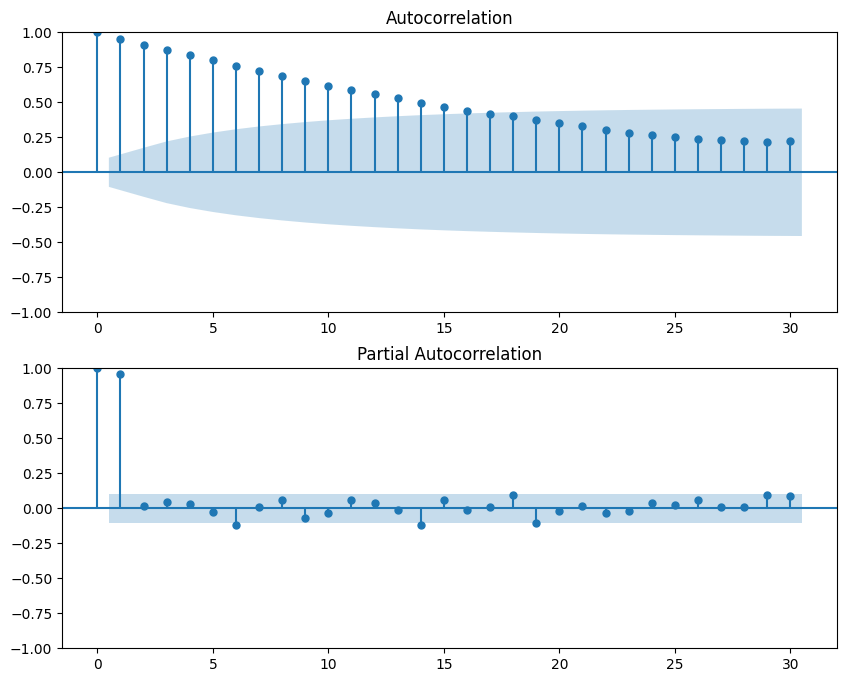

In [13]:
# Plot ACF and PACF to determine p and q values
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(train_log, lags=30, ax=ax[0])
plot_pacf(train_log, lags=30, ax=ax[1])
plt.show()

Penjelasan dari grafik diatas adalah :ACF harus menunjukkan penurunan tajam setelah jumlah kelambatan q tertentu sehingga didapatkan nilai (1) sementara PACF harus menunjukkan tren penurunan geometrik atau bertahap sehingga mendapatkan nilai (1).

# Menghitung nilai d menggunakan differencing (untuk membuat data stationary):

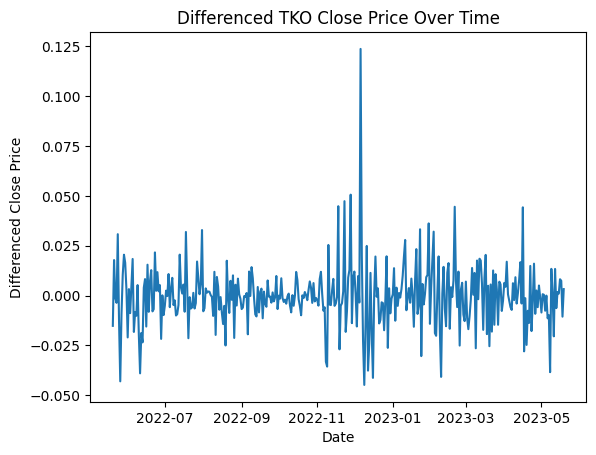

In [14]:
# Differencing dengan lag 1
data_diff = data['Close'].diff().dropna()

# Visualisasi data differencing
plt.plot(data_diff)
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.title('Differenced TKO Close Price Over Time')
plt.show()

In [15]:
adf_result = adfuller(data['Close'])
print(f'ADF Statistic: {adf_result[0]:.3f}')
print(f'p-value: {adf_result[1]:.3f}')

ADF Statistic: -3.127
p-value: 0.025


dari hasil ini dapat disimpulkan bahwa nilai sactionarynya adalah (1) dikarekan hasil adfuller bernilai negatif dan p-valuenya bernilai lebih kecil dari 0.05

In [16]:
d = 0
diff = train_log
while True:
    d += 1
    diff = np.diff(diff)
    _, p_value, _, _, _, _ = adfuller(diff)
    if p_value < 0.05:
        break

In [17]:
print("Nilai d yang ditemukan:", d)

Nilai d yang ditemukan: 1


# Melatih model ARIMA dan membuat prediksi:

In [18]:
# Fit ARIMA model
model = ARIMA(train_log, order=(1, 1, 1)) #(p,d,q)
model_fit = model.fit()

In [19]:
# Melakukan prediksi
start_index = len(train_data)
end_index = len(train_data) + len(test_data) - 1

In [20]:
# Make predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [21]:
# Membuat DataFrame untuk prediksi
predictions_df = pd.DataFrame(predictions, index=test_data.index, columns=['Predicted'])

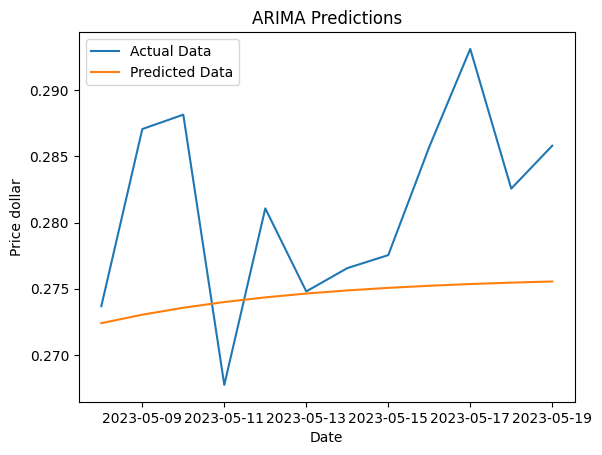

            Predicted
Date                 
2023-05-08   0.272393
2023-05-09   0.273035
2023-05-10   0.273561
2023-05-11   0.273991
2023-05-12   0.274344
2023-05-13   0.274633
2023-05-14   0.274870
2023-05-15   0.275063
2023-05-16   0.275222
2023-05-17   0.275352
2023-05-18   0.275459
2023-05-19   0.275546


In [22]:
# Menampilkan grafik data aktual dan hasil prediksi
#plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data')
plt.plot(predictions_df.index, predictions_df['Predicted'], label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Price dollar')
plt.title('ARIMA Predictions')
plt.legend()
plt.show()

# Menampilkan nilai prediksi
print(predictions_df)